# StanCon 2018 Helsinki Intro Workshop

### Setup

In [1]:
import os
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import cmdstanpy
from cmdstanpy import CmdStanModel

from matplotlib import style 
style.use('../../../PlottingStyle.mplstyle')

import gc

%config InlineBackend.figure_formats = ['svg']

In [2]:
def StanModel(stan_file: str, stan_code: str) -> CmdStanModel:
    """Load or compile a Stan model"""
    stan_src = f"{stan_file}.stan"

    if not os.path.isfile(stan_file):  
        open(stan_src, 'w').write(stan_code)  # Write Stan code if needed
        return CmdStanModel(stan_file=stan_src, cpp_options={'STAN_THREADS': 'true', 'parallel_chains': 4})
    
    return CmdStanModel(stan_file=stan_src, exe_file=stan_file)

def bw_nrd0(x):
    if len(x) < 2:
        raise(Exception("need at least 2 data points"))

    hi = np.std(x, ddof=1)
    q75, q25 = np.percentile(x, [75 ,25])
    iqr = q75 - q25
    lo = min(hi, iqr/1.34)
    
    lo = lo or hi or abs(x[0]) or 1

    return 0.9 * lo *len(x)**-0.2

## The Problem

### Background

Imagine that you are a statistician or data scientist working as an independent contractor. One of your clients is a company that owns many residential buildings throughout New York City. The property manager explains that they are concerned about the number of cockroach complaints that they receive from their buildings. Previously the company has offered monthly visits from a pest inspector as a solution to this problem. While this is the default solution of many property managers in NYC, the tenants are rarely home when the inspector visits, and so the manager reasons that this is a relatively expensive solution that is currently not very effective.

One alternative to this problem is to deploy long term bait stations. In this alternative, child and pet safe bait stations are installed throughout the apartment building. Cockroaches obtain quick acting poison from these stations and distribute it throughout the colony. The manufacturer of these bait stations provides some indication of the space-to-bait efficacy, but the manager suspects that this guidance was not calculated with NYC roaches in mind. NYC roaches, the manager rationalizes, have more hustle than traditional roaches; and NYC buildings are built differently than other common residential buildings in the US. This is particularly important as the unit cost for each bait station per year is quite high.

### The Goal

The manager wishes to employ your services to help them to find the optimal number of roach bait stations they should place in each of their buildings in order to minimize the number of cockroach complaints while also keeping expenditure on pest control affordable. 

A subset of the company's buildings have been randomly selected for an experiment: 
- At the beginning of each month, a pest inspector randomly places a number of bait stations throughout the building, without knowledge of the current cockroach levels in the building
- At the end of the month, the manager records the total number of cockroach complaints in that building. 
- The manager would like to determine the optimal number of traps ($\textrm{traps}$) that balances the lost revenue ($R$) that complaints ($\textrm{complaints}$) generate with the all-in cost of maintaining the traps ($\textrm{TC}$). 

Fortunately, Bayesian data analysis provides a coherent framework for us to tackle this problem.

Formally, we are interested in finding:
$$
\arg\max_{\textrm{traps} \in \mathbb{N}} \mathbb{E}_{\text{complaints}}[R(\textrm{complaints}(\textrm{traps})) - \textrm{TC}(\textrm{traps})]
$$

The property manager would also, if possible, like to learn how these results generalize to buildings they haven't treated so they can understand the potential costs of pest control at buildings they are acquiring as well as for the rest of their building portfolio.

As the property manager has complete control over the number of traps set, the random variable contributing to this expectation is the number of complaints given the number of traps. We will model the number of complaints as a function of the number of traps.

## The Data

The data provided to us is in a file called `pest_data.csv`. Let's load the data and see what the structure is:

In [3]:
pest_data = pd.read_csv('data/pest_data.csv', sep=',', header=0, parse_dates=['date'])
pest_data.head()

,Unnamed: 0,mus,building_id,wk_ind,date,traps,floors,sq_footage_p_floor,live_in_super,monthly_average_rent,average_tenant_age,age_of_building,total_sq_foot,month,complaints
0,1,0.369134,37,1,2017-01-15,8,8,5149.008112,0,3846.94905,53.877424,47,41192.064892,1,1
1,2,0.359355,37,2,2017-02-14,8,8,5149.008112,0,3846.94905,53.877424,47,41192.064892,2,3
2,3,0.281783,37,3,2017-03-16,9,8,5149.008112,0,3846.94905,53.877424,47,41192.064892,3,0
3,4,0.129254,37,4,2017-04-15,10,8,5149.008112,0,3846.94905,53.877424,47,41192.064892,4,1
4,5,0.452041,37,5,2017-05-15,11,8,5149.008112,0,3846.94905,53.877424,47,41192.064892,5,0


We have access to the following fields: 

* `complaints`: Number of complaints per building per month
* `building_id`: The unique building identifier
* `traps`: The number of traps used per month per building
* `date`: The date at which the number of complaints are recorded
* `live_in_super`: An indicator for whether the building as a live-in super
* `age_of_building`: The age of the building
* `total_sq_foot`: The total square footage of the building
* `average_tenant_age`: The average age of the tenants per building
* `monthly_average_rent`: The average monthly rent per building
* `floors`: The number of floors per building

First, let's see how many buildings we have data for:

In [4]:
N_buildings = len(pest_data.building_id.unique())
N_buildings

10

And make some plots of the raw data: 

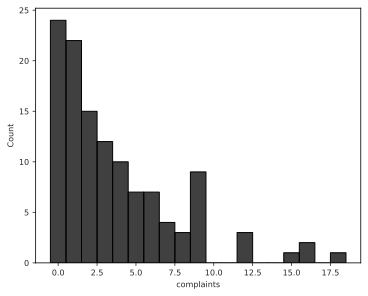

In [5]:
sns.histplot(pest_data.complaints, discrete=True);

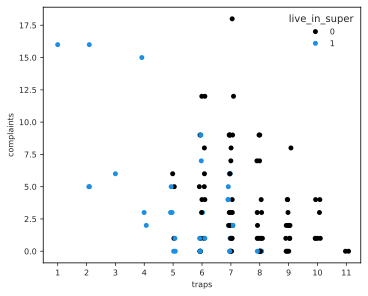

In [6]:
sns.stripplot(data=pest_data, x='traps', y='complaints', hue='live_in_super', jitter=True);

/Users/rehabnaeem/Documents/Coding-Projects/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


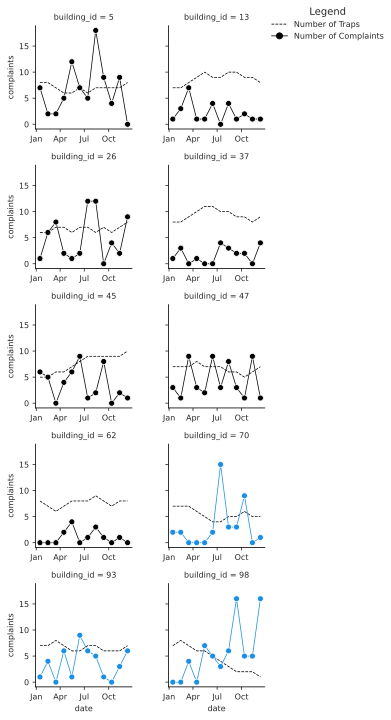

In [7]:
import matplotlib.dates as mdates

g = sns.FacetGrid(data=pest_data, col='building_id', hue='live_in_super', col_wrap=2, height=2, sharex=False)
g.map_dataframe(sns.lineplot, 'date', 'traps', linestyle='dashed', color='k', label='Number of Traps')
g.map_dataframe(sns.lineplot, x='date', y='complaints', marker='o', label='Number of Complaints')

for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Show only abbreviated month names (e.g., Jan, Feb)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set ticks at the start of each month

line_labels = [
    plt.Line2D([0], [0], color='k', linestyle='dashed', label="Number of Traps"),
    plt.Line2D([0], [0], marker='o', color='k', label="Number of Complaints", linestyle='solid')
]
g.add_legend(handles=line_labels, title='Legend', loc='upper right')   

The first question we'll look at is just whether the number of complaints per building per month is associated with the number of bait stations per building per month, ignoring the temporal and across-building variation (we'll come back to those sources of variation later in the document). That requires only two variables, $\textrm{complaints}$ and $\textrm{traps}$. How should we model the number of complaints?

## Bayesian Workflow

- Exploratory data analysis
- Prior predictive checking
- Model fitting and algorithm diagnostics
- Posterior predictive checking
- Model comparison (e.g., via cross-validation)

## Modeling count data: Poisson distribution

We already know some rudimentary information about what we should expect. The number of complaints over a month should be either zero or an integer. The property manager tells us that it is possible but unlikely that number of complaints in a given month is zero. Occasionally there are a very large number of complaints in a single month. A common way of modeling this sort of skewed, single bounded count data is as a Poisson random variable. One concern about modeling the outcome variable as Poisson is that the data may be over-dispersed, but we'll start with the Poisson model and then check whether over-dispersion is a problem by comparing our model's predictions to the data.

### Model

Given that we have chosen a Poisson regression, we define the likelihood to be the Poisson probability mass function over the number bait stations placed in the building, denoted below as `traps`. This model assumes that the mean and variance of the outcome variable `complaints` (number of complaints) is the same. We'll investigate whether this is a good assumption after we fit the model.

For building $b = 1,\dots,10$ at time (month) $t = 1,\dots,12$, we have

$$
\begin{align*}
\textrm{complaints}_{b,t} & \sim \textrm{Poisson}(\lambda_{b,t}) \\
\lambda_{b,t} & = \exp{(\eta_{b,t})} \\
\eta_{b,t} &= \alpha + \beta \, \textrm{traps}_{b,t}
\end{align*}
$$

Let's encode this probability model in a Stan program. 

### Writing our first Stan model

In [8]:
simple_poisson_regression = '''
functions {
  /*
  * Alternative to poisson_log_rng() that 
  * avoids potential numerical problems during warmup
  */
  int poisson_log_safe_rng(real eta) {
    real pois_rate = exp(eta);
    if (pois_rate >= exp(20.79))
      return -9;
    return poisson_rng(pois_rate);
  }
}
data {
    int<lower=1> N;
    array[N] int<lower=0> complaints;
    vector<lower=0>[N] traps;
}
parameters {
    real alpha;
    real beta;
}
model {
  // weakly informative priors:
  // we expect negative slope on traps and a positive intercept,
  // but we will allow ourselves to be wrong
  beta ~ normal(-0.25, 1);
  alpha ~ normal(log(4), 1);
  
  // poisson_log(eta) is more efficient and stable alternative to poisson(exp(eta))
  complaints ~ poisson_log(alpha + beta * traps);
} 
generated quantities {
    array[N] int y_rep;

    for (n in 1:N) {
        y_rep[n] = poisson_log_safe_rng(alpha + beta * traps[n]);
    }
}
'''

simple_poisson_regression_model = StanModel('../stan_models/simple_poisson_regression', simple_poisson_regression)

### Making sure our code is right

However, before we fit the model to real data, we should check that our model works well with simulated data. We'll simulate data according to the model and then check that we can sufficiently recover the parameter values used in the simulation.

In [9]:
simple_poisson_regression_dgp_model = '''
data {
    int<lower=1> N;
    real<lower=0> mean_traps;
}
model {
} 
generated quantities {
    array[N] int traps;
    array[N] int complaints;
    real alpha = normal_rng(log(4), .1);
    real beta = normal_rng(-0.25, .1);

    for (n in 1:N)  {
        traps[n] = poisson_rng(mean_traps);
        complaints[n] = poisson_log_rng(alpha + beta * traps[n]);
    }
}
'''

Here we will do the *compilation* and *fitting* in two stages to demonstrate what is happening under the hood. 

First we will compile the Stan program (`simple_poisson_regression_dgp.stan`) that will generate the fake data.

In [10]:
simple_poisson_regression_dgp = StanModel('../stan_models/simple_poisson_regression_dgp', simple_poisson_regression_dgp_model)

Now we can simulate the data by calling the `sample()` method on the CmdStanModel object instantiated above. The method requires that we pass input data in the form of a dictionary. The names must match the names used in the `data` block of the Stan program.

In [11]:
fitted_model_dgp = simple_poisson_regression_dgp.sample(
    data={'N': len(pest_data.traps), 
          'mean_traps': pest_data.traps.mean()},
    chains=1,
    iter_sampling=1,
    show_progress=False
)

samps_dgp = az.from_cmdstanpy(fitted_model_dgp)
samps_dgp

09:17:27 - cmdstanpy - INFO - CmdStan start processing
09:17:27 - cmdstanpy - INFO - Chain [1] start processing
09:17:27 - cmdstanpy - INFO - Chain [1] done processing


Inference data with groups:
	> posterior
	> sample_stats

### Fit the model to the fake data

In order to pass the fake data to our Stan program, we need to arrange the data into a dictionary. The keys must match the names used in the `data` block of the Stan program.

In [12]:
stan_dat_fake = {
    'N': len(pest_data.traps),
    'traps': samps_dgp.posterior.traps.sel(chain=0, draw=0).to_numpy().astype(np.int16),
    'complaints': samps_dgp.posterior.complaints.sel(chain=0, draw=0).to_numpy().astype(np.int16)
}

Now that we have the simulated data we fit the model to see if we can recover the `alpha` and `beta` parameters used in the simulation.

In [13]:
fit_model_P = simple_poisson_regression_model.sample(data=stan_dat_fake,
                                                     show_progress=False)
posterior_alpha_beta = az.extract(az.from_cmdstanpy(fit_model_P), 'posterior', var_names=['alpha', 'beta']).to_dataframe()[['alpha', 'beta']]

09:17:27 - cmdstanpy - INFO - CmdStan start processing
09:17:27 - cmdstanpy - INFO - CmdStan start processing
09:17:27 - cmdstanpy - INFO - CmdStan done processing


### Assess parameter recovery

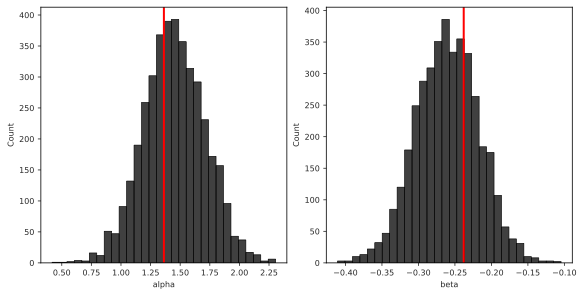

In [14]:
true_alpha = samps_dgp.posterior.alpha.sel(chain=0, draw=0).to_numpy()
true_beta = samps_dgp.posterior.beta.sel(chain=0, draw=0).to_numpy()

_, ax = plt.subplots(1,2, figsize=(8,4))
sns.histplot(posterior_alpha_beta, x='alpha', bins=30, ax=ax[0])
ax[0].axvline(true_alpha, color='r', linewidth=2)
sns.histplot(posterior_alpha_beta, x='beta', bins=30, ax=ax[1])
ax[1].axvline(true_beta, color='r', linewidth=2);

We don't do a great job recovering the parameters here simply because we're simulating so few observations that the posterior uncertainty remains rather large, but it looks at least _plausible_ ($\alpha$ and $\beta$ are contained within the histograms). If we did the simulation with many more observations the parameters would be estimated much more precisely.

We should also check if the `y_rep` datasets (in-sample predictions) that we coded in the `generated quantities` block are similar to the `y` (complaints) values we conditioned on when fitting the model.

Here is a plot of the density estimate of the observed data compared to 200 of the `y_rep` datasets: 

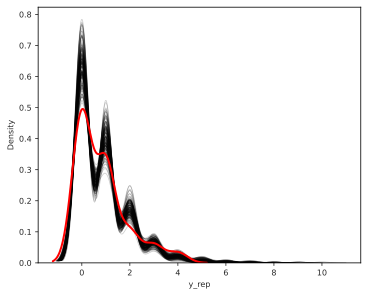

In [15]:
y_rep = az.from_cmdstanpy(fit_model_P).posterior.y_rep

for i in range(200):
    sns.kdeplot(y_rep.sel(chain=slice(0,4), draw=i).to_dataframe(), x='y_rep', color='k', alpha=0.2)
sns.kdeplot(stan_dat_fake['complaints'], color='r', linewidth=2);

In the plot above we have the kernel density estimate of the observed data ($y$, thicker curve) and 200 simulated data sets ($y_{rep}$, thin curves) from the posterior predictive distribution. If the model fits the data well, as it does here, there is little difference between the observed dataset and the simulated datasets.

Another plot we can make for count data is a rootogram. This is a plot of the expected counts (continuous line) vs the observed counts (blue histogram). We
can see the model fits well because the observed histogram matches the expected counts relatively well.

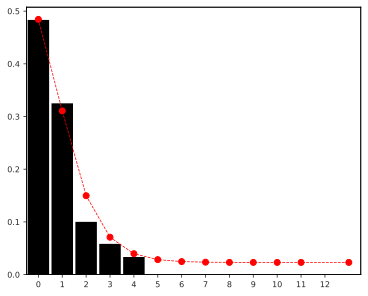

In [16]:
fig, ax = plt.subplots()
vals, counts = np.unique(y_rep.to_dataframe()['y_rep'].to_numpy(), return_counts=True)
hist_range = (min(vals), max(vals))
az.plot_dist(stan_dat_fake['complaints'], kind='hist', ax=ax, 
             hist_kwargs={'bins': np.arange(hist_range[0], hist_range[1] + 1, 1), 'range': hist_range})

secax = ax.twinx()
secax.plot(vals, counts, color='red', linestyle='dashed', marker='o')

ax.set_xlim(hist_range[0]-0.5, hist_range[1]+0.5)

secax.set_yticklabels([])
secax.yaxis.set_ticks([]);

### Fit with real data 

To fit the model to the actual observed data we'll first create a dictionary to pass to Stan using the variables in the `pest_data` data frame:

In [17]:
stan_dat_simple = {
    'N': len(pest_data.traps),
    'complaints': pest_data.complaints,
    'traps': pest_data.traps
}

In [18]:
fit_P_real_data = simple_poisson_regression_model.sample(data=stan_dat_simple, show_progress=False)
az_fit_P_real_data = az.from_cmdstanpy(fit_P_real_data, posterior_predictive='y_rep')

summary = fit_P_real_data.summary(percentiles=(2.5, 25, 50, 75, 97.5))
summary[~summary.index.str.contains('y_rep')]

09:17:28 - cmdstanpy - INFO - CmdStan start processing
09:17:28 - cmdstanpy - INFO - CmdStan start processing
09:17:29 - cmdstanpy - INFO - CmdStan done processing


,Mean,MCSE,StdDev,MAD,2.5%,25%,50%,75%,97.5%,ESS_bulk,ESS_tail,R_hat
lp__,160.812000,0.034745,1.037700,0.730922,158.008000,160.414000,161.126000,161.540000,161.802000,1054.440,1187.790,1.00632
alpha,2.577270,0.005445,0.153422,0.150113,2.262560,2.476150,2.583550,2.678340,2.871950,790.639,812.688,1.00607
beta,-0.191704,0.000824,0.023180,0.022889,-0.236137,-0.207131,-0.192034,-0.176418,-0.145635,782.667,827.329,1.00614


We can also plot the posterior distributions: 

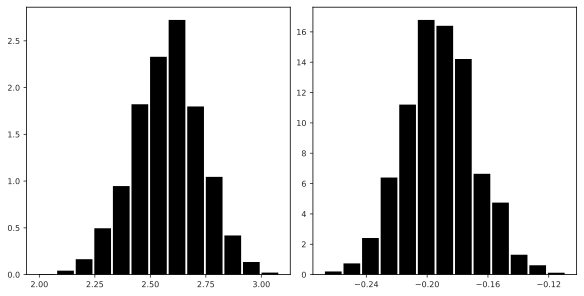

In [ ]:
import matplotlib.ticker as mticker

_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_dist(az_fit_P_real_data.posterior.alpha, kind='hist', ax=ax[0])
az.plot_dist(az_fit_P_real_data.posterior.beta, kind='hist', ax=ax[1])
for a in ax:
    a.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5))

As we expected, it appears the number of bait stations set in a building is associated with the number of complaints about cockroaches that were made in the following month. However, we still need to consider how well the model fits.

### Posterior predictive checking

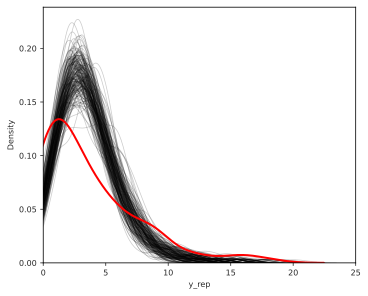

In [20]:
y_rep = az_fit_P_real_data.posterior_predictive.y_rep

for i in range(200):
    sns.kdeplot(y_rep.sel(chain=slice(0), draw=i).to_dataframe(), x='y_rep', color='k', alpha=0.2)
sns.kdeplot(stan_dat_simple['complaints'], color='r', linewidth=2)
plt.xlim(0,25);

As opposed to when we fit the model to simulated data above, here the simulated datasets is not as dispersed as the observed data and don't seem to capture the rate of zeros in the observed data. The Poisson model may not be sufficient for this data.

Let's explore this further by looking directly at the proportion of zeros in the real data and predicted data.

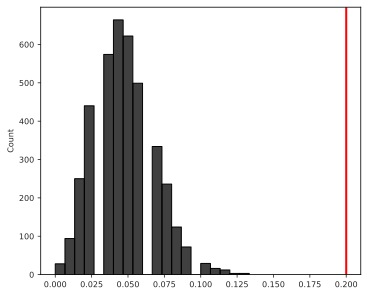

In [21]:
_, ax = plt.subplots()
sns.histplot(np.mean(y_rep == 0, axis=2).to_numpy().flatten(), bins=20, ax=ax)
ax.axvline(np.mean(stan_dat_simple['complaints'] == 0), linewidth=2, color='r');

The plot above shows the observed proportion of zeros (thick vertical line) and a histogram of the proportion of zeros in each of the simulated data sets. It is clear that the model does not capture this feature of the data well at all.

This next plot is a plot of the standardised residuals of the observed vs predicted number of complaints. 

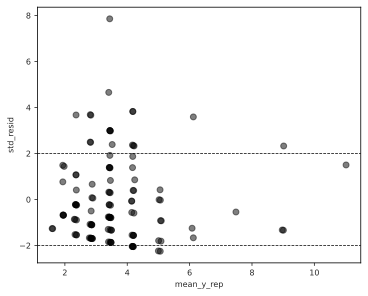

In [22]:
mean_y_rep = y_rep.mean(dim=['chain', 'draw'])
std_resid = (stan_dat_simple['complaints'] - mean_y_rep) / np.sqrt(mean_y_rep)
plt.plot(mean_y_rep, std_resid, 'o', alpha=0.5)
plt.axhline(2, linestyle='--')
plt.axhline(-2, linestyle='--')
plt.xlabel('mean_y_rep')
plt.ylabel('std_resid');

As you can see here, it looks as though we have more positive residuals than negative, which indicates that the model tends to underestimate the number of complaints that will be received.

Below another useful plot to compare the observed vs expected number of complaints. This is a plot of the expected counts (continuous line) vs the observed counts (black histogram):

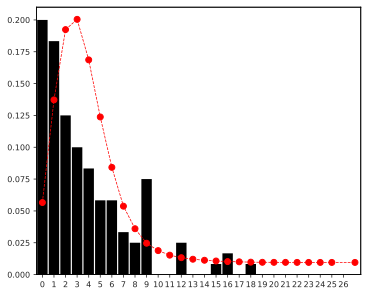

In [23]:
fig, ax = plt.subplots()
vals, counts = np.unique(y_rep, return_counts=True)
hist_range = (min(vals), max(vals))
az.plot_dist(stan_dat_simple['complaints'], kind='hist', ax=ax, 
             hist_kwargs={'bins': np.arange(hist_range[0], hist_range[1] + 1, 1), 'range': hist_range})

secax = ax.twinx()
secax.plot(vals, counts, color='red', linestyle='dashed', marker='o')

ax.set_xlim(hist_range[0]-0.5, hist_range[1]+0.5)

secax.set_yticklabels([])
secax.yaxis.set_ticks([]);

If the model was fitting well these would be relatively similar, however in this figure we can see the number of complaints is underestimated if there are few complaints, over-estimated for medium numbers of complaints, and underestimated if there are a large number of complaints.

We can also view how the predicted number of complaints varies with the number of traps. From this we can see that the model doesn't seem to fully capture the data.

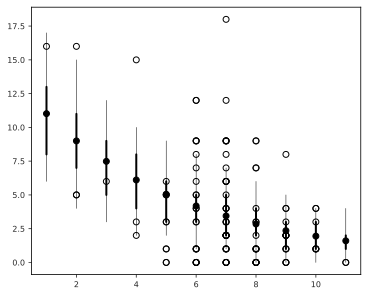

In [24]:
from collections import defaultdict

_, ax = plt.subplots()

ax.plot(stan_dat_simple['traps'], stan_dat_simple['complaints'], 'o', fillstyle='none')

grouped_indices = defaultdict(list)
for idx, trap in enumerate(stan_dat_simple['traps']):
    grouped_indices[trap].append(idx)

grouped_array = {trap: y_rep[:, :, idx_list].to_numpy().flatten() for trap, idx_list in grouped_indices.items()}

for traps_x, complaints_y in grouped_array.items():
    inner_prob = np.array([np.quantile(complaints_y, 0.75), np.quantile(complaints_y, 0.25)])  # az.hdi(complaints_y, hdi_prob=0.5)
    outer_prob = np.array([np.quantile(complaints_y, 0.95), np.quantile(complaints_y, 0.05)])  # az.hdi(complaints_y, hdi_prob=0.9)
    ax.plot(np.full(inner_prob.shape, traps_x), inner_prob, 'k', linewidth=2)
    ax.plot(np.full(outer_prob.shape, traps_x), outer_prob, 'k', linewidth=0.5)
    ax.plot(traps_x, np.mean(complaints_y), 'ko')

Specifically, the model doesn't capture the tails of the observed data very well.

## Expanding the model: multiple predictors

Modeling the relationship between complaints and bait stations is the simplest model. We can expand the model, however, in a few ways that will be beneficial for our client. Moreover, the manager has told us that they expect there are a number of other reasons that one building might have more roach complaints than another.

### Interpretability

Currently, our model's mean parameter is a rate of complaints per 30 days, but we're modeling a process that occurs over an area as well as over time. We have the square footage of each building, so if we add that information into the model, we can interpret our parameters as a rate of complaints per square foot per 30 days.

$$
\begin{align*}
\textrm{complaints}_{b,t} & \sim \textrm{Poisson}(\textrm{sq. foot}_b\,\lambda_{b,t}) \\
\lambda_{b,t} & = \exp{(\eta_{b,t} )} \\
\eta_{b,t} &= \alpha + \beta \, \textrm{traps}_{b,t}
\end{align*}
$$

The term $\text{sq. foot}$ is called an exposure term. If we log the term, we can put it in $\eta_{b,t}$:

$$
\begin{align*}
\textrm{complaints}_{b,t} & \sim \textrm{Poisson}(\lambda_{b,t}) \\
\lambda_{b,t} & = \exp{(\eta_{b,t} )} \\
\eta_{b,t} &= \alpha + \beta \, \textrm{traps}_{b,t} + \textrm{log sq. foot}_b
\end{align*}
$$